# Libraries

In [1]:
import random
import ray
import tensorflow as tf
import utils
from gym import spaces
from ray.rllib.algorithms.sac import SAC
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.algorithms.sac.sac_tf_model import SACTFModel
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.typing import ModelConfigDict, TensorType
from environments.cartpole import CartPoleEnv

# Custom Model

In [2]:
class CustomTFModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name
        )

        inputs = tf.keras.layers.Input(shape=obs_space.shape, name='observations')
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_1')(inputs)
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_2')(x)
        policy_out = tf.keras.layers.Dense(units=num_outputs, name='policy_out')(x)
        value_out = tf.keras.layers.Dense(units=1, name='value_out')(x)
        self.base_model = tf.keras.Model(inputs, [policy_out, value_out])

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model(input_dict["obs"])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])


class SACCustomModel(SACTFModel):
    def __init__(
            self,
            obs_space: spaces.Space,
            action_space: spaces.Space,
            num_outputs: int,
            model_config: ModelConfigDict,
            name: str,
            policy_model_config: ModelConfigDict=None,
            q_model_config: ModelConfigDict=None,
            twin_q: bool=False,
            initial_alpha: float=1.0,
            target_entropy: float=None,
    ):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name,
            policy_model_config=policy_model_config,
            q_model_config=q_model_config,
            twin_q=twin_q,
            initial_alpha=initial_alpha,
            target_entropy=target_entropy
        )

    def build_policy_model(self, obs_space, num_outputs, policy_model_config, name):
        return CustomTFModel(
            obs_space=obs_space,
            action_space=self.action_space,
            num_outputs=num_outputs,
            model_config=policy_model_config,
            name=name
        )

    def build_q_model(self, obs_space, action_space, num_outputs, q_model_config, name):
        self.concat_obs_and_actions = False
        if self.discrete:
            input_space = obs_space
        else:
            orig_space = getattr(obs_space, "original_space", obs_space)
            if isinstance(orig_space, spaces.Box) and len(orig_space.shape) == 1:
                input_space = spaces.Box(
                    float("-inf"),
                    float("inf"),
                    shape=(orig_space.shape[0] + action_space.shape[0],),
                )
                self.concat_obs_and_actions = True
            else:
                input_space = spaces.Tuple([orig_space, action_space])

        return CustomTFModel(
            obs_space=obs_space,
            action_space=self.action_space,
            num_outputs=num_outputs,
            model_config=q_model_config,
            name=name
        )

# Train Default Model

2023-01-03 13:16:06,055	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-03 13:16:07,335	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'environments.cartpole.CartPoleEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'environments.cartpole.CartPoleEnv'>').build()` instead. This will raise an error in the future!
2023-01-03 13:16:09,421	WARNING util.py:66 -- Install gputil for GPU system monitoring.


--- Policy Model ---
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 fc_1 (Dense)                   (None, 256)          1280        ['observations[0][0]']           
                                                                                                  
 fc_2 (Dense)                   (None, 256)          65792       ['fc_1[0][0]']                   
                                                                                                  
 fc_out (Dense)                 (None, 2)            514         ['fc_2[0][0]']                   
                                                                       

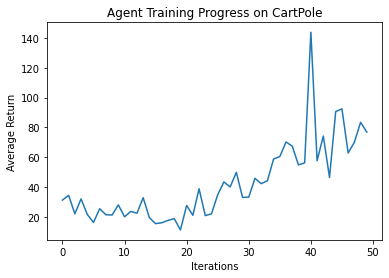

[31.2,
 34.4,
 22.0,
 32.0,
 21.6,
 16.2,
 25.4,
 21.4,
 21.2,
 28.0,
 20.0,
 23.6,
 22.4,
 32.8,
 19.4,
 15.4,
 16.0,
 17.6,
 18.8,
 11.2,
 27.6,
 21.0,
 38.8,
 20.8,
 22.0,
 34.8,
 43.4,
 40.0,
 49.8,
 33.0,
 33.2,
 45.8,
 42.2,
 44.2,
 58.8,
 60.4,
 70.2,
 67.4,
 54.8,
 56.2,
 143.8,
 57.6,
 74.2,
 46.4,
 90.6,
 92.4,
 62.8,
 70.0,
 83.4,
 76.8]

In [41]:
ray.shutdown()
ray.init()
tf.random.set_seed(seed=0)
random.seed(0)
agent = SAC(env=CartPoleEnv, config={
    'env_config': {'verbose': False},
    'replay_buffer_config' : {
        "type": 'MultiAgentPrioritizedReplayBuffer',
        'prioritized_replay': True,
        "capacity": 50000,
        'prioritized_replay_alpha': 0.6,
        'prioritized_replay_beta': 0.4,
        'prioritized_replay_eps': 1e-6,
        'replay_sequence_length': 1,
    },
    'num_steps_sampled_before_learning_starts': 5000,
    'target_network_update_freq': 1,
    'tau': 0.005,
    'train_batch_size': 256,
    'n_step': 3,
    'twin_q': True,
    'initial_alpha': 1.0,
    'target_entropy': 'auto',
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.001,
    'num_gpus': 1
})
print('--- Policy Model ---')
agent.get_policy().target_model.action_model.base_model.summary(expand_nested=True)
print('--- Q-Model Model ---')
agent.get_policy().target_model.q_net.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))

# Train Custom Model

2023-01-03 13:47:57,099	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-03 13:47:58,556	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'environments.cartpole.CartPoleEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'environments.cartpole.CartPoleEnv'>').build()` instead. This will raise an error in the future!
2023-01-03 13:48:00,843	WARNING util.py:66 -- Install gputil for GPU system monitoring.


--- Policy Model ---
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 hidden_1 (Dense)               (None, 256)          1280        ['observations[0][0]']           
                                                                                                  
 hidden_2 (Dense)               (None, 256)          65792       ['hidden_1[0][0]']               
                                                                                                  
 policy_out (Dense)             (None, 2)            514         ['hidden_2[0][0]']               
                                                                       

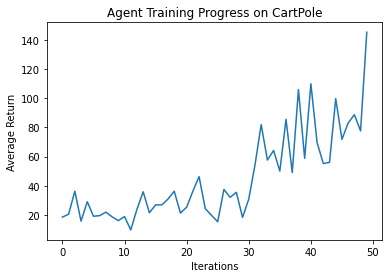

[18.4,
 20.4,
 36.2,
 15.6,
 29.0,
 19.0,
 19.4,
 21.8,
 18.6,
 16.0,
 18.8,
 9.6,
 23.8,
 35.8,
 21.4,
 26.8,
 26.8,
 30.8,
 36.2,
 21.2,
 25.2,
 36.2,
 46.2,
 24.2,
 19.6,
 15.2,
 37.4,
 32.0,
 35.4,
 18.2,
 30.8,
 54.2,
 82.0,
 57.6,
 64.2,
 50.0,
 85.6,
 49.0,
 106.0,
 58.8,
 110.0,
 69.6,
 55.2,
 56.0,
 99.8,
 71.8,
 83.0,
 88.8,
 77.6,
 145.4]

In [43]:
ray.shutdown()
ray.init()
ModelCatalog.register_custom_model("sac_model", SACCustomModel)
tf.random.set_seed(seed=0)
random.seed(0)
agent = SAC(env=CartPoleEnv, config={
    'env_config': {'verbose': False},
    'model': {
        'custom_model': 'sac_model',
        'custom_model_config': {}
    },
    'replay_buffer_config' : {
        "type": 'MultiAgentPrioritizedReplayBuffer',
        'prioritized_replay': True,
        "capacity": 50000,
        'prioritized_replay_alpha': 0.6,
        'prioritized_replay_beta': 0.4,
        'prioritized_replay_eps': 1e-6,
        'replay_sequence_length': 1,
    },
    'num_steps_sampled_before_learning_starts': 5000,
    'target_network_update_freq': 1,
    'tau': 0.005,
    'train_batch_size': 256,
    'n_step': 3,
    'twin_q': True,
    'initial_alpha': 1.0,
    'target_entropy': 'auto',
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.001,
    'num_gpus': 1
})
print('--- Policy Model ---')
agent.get_policy().target_model.action_model.base_model.summary(expand_nested=True)
print('--- Q-Model Model ---')
agent.get_policy().target_model.q_net.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))